## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
# import parfit.parfit as pf
from sklearn import metrics
from sklearn.metrics import classification_report 
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Reading Train and Test data

In [2]:
train_data = pd.read_csv('train_E6oV3lV.csv')
test_data = pd.read_csv('test_tweets_anuFYb8.csv')
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


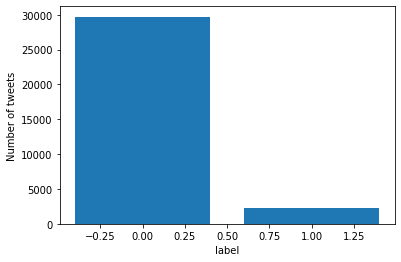

In [4]:
# Checking for data is balanced or not

label_count=train_data.groupby('label').count()
plt.bar(label_count.index.values, label_count['tweet'])
plt.xlabel('label')
plt.ylabel('Number of tweets')
plt.show()

## Data cleaning and Preprocessing

In [7]:
def transformation(data):   
    # upper to lower character
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #punctuations
    data['tweet'] = data['tweet'].str.replace('[^\w\s]','')
    #numbers
    data['tweet'] = data['tweet'].str.replace('\d','')
    sw = stopwords.words('english')
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
    #lemmi
    from textblob import Word
    #nltk.download('wordnet')
    data['tweet'] = data['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
    return data

In [8]:
from nltk.corpus import stopwords
train_data = transformation(train_data)
test_data = transformation(test_data)
train_data.head()

,id,label,tweet
0,1,0,user father dysfunctional selfish drag kid dys...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time urð ðððð ððð
4,5,0,factsguide society motivation


In [9]:
test_data.head()

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,user white supremacist want everyone see new â...
2,31965,safe way heal acne altwaystoheal healthy healing
3,31966,hp cursed child book reservation already yes ð...
4,31967,rd bihday amazing hilarious nephew eli ahmir u...


In [11]:
# nltk inbuild method which gives us probabilities of positiveness,negativeness and neutralness of tweet

sid = SentimentIntensityAnalyzer()
train_data['scores'] = train_data['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
train_data['compound']  = train_data['scores'].apply(lambda score_dict: score_dict['compound'])
train_data['comp_score'] = train_data['compound'].apply(lambda c: 0 if c >=0 else 1)

test_data['scores'] = test_data['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
test_data['compound']  = test_data['scores'].apply(lambda score_dict: score_dict['compound'])
test_data['comp_score'] = test_data['compound'].apply(lambda c: 0 if c >=0 else 1)

train_data.head()

,id,label,tweet,scores,compound,comp_score
0,1,0,user father dysfunctional selfish drag kid dys...,"{'neg': 0.609, 'neu': 0.391, 'pos': 0.0, 'comp...",-0.7783,1
1,2,0,user user thanks lyft credit cant use cause do...,"{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp...",0.6705,0
2,3,0,bihday majesty,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
3,4,0,model love u take u time urð ðððð ððð,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.6369,0
4,5,0,factsguide society motivation,"{'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'comp...",0.3400,0


In [12]:
test_data.head()

,id,tweet,scores,compound,comp_score
0,31963,studiolife aislife requires passion dedication...,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...",0.4588,0
1,31964,user white supremacist want everyone see new â...,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...",0.2023,0
2,31965,safe way heal acne altwaystoheal healthy healing,"{'neg': 0.0, 'neu': 0.472, 'pos': 0.528, 'comp...",0.6808,0
3,31966,hp cursed child book reservation already yes ð...,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp...",0.6908,0
4,31967,rd bihday amazing hilarious nephew eli ahmir u...,"{'neg': 0.0, 'neu': 0.428, 'pos': 0.572, 'comp...",0.8934,0


In [13]:
# Separating X and y variable for train a model

X_train = train_data[['tweet','compound','comp_score']]
y_train = train_data['label']
X_test = test_data[['tweet','compound','comp_score']]

## Applying TFIDF vectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['tweet']).toarray()
X_test_tfidf = vectorizer.transform(X_test['tweet']).toarray()

In [15]:
X_train_tfidf = pd.DataFrame(X_train_tfidf)
X_test_tfidf = pd.DataFrame(X_test_tfidf)
X_train_tfidf['compound'] = train_data['compound']
X_test_tfidf['compound'] = test_data['compound']
X_train_tfidf['compound'] = train_data['comp_score']
X_test_tfidf['compound'] = test_data['comp_score']

## Training model with NaiveBayes

In [16]:
nbmodeltfidf = MultinomialNB(alpha=0.01)
nbmodeltfidf.fit(X_train_tfidf,y_train)
pred_nb_tfidf_train = nbmodeltfidf.predict(X_train_tfidf)
pred_nb_tfidf_test = nbmodeltfidf.predict(X_test_tfidf)
print(metrics.confusion_matrix(y_train,pred_nb_tfidf_train))
print('classification report===============')
print(classification_report(y_train,pred_nb_tfidf_train))
print('f1 score:',f1_score(y_train,pred_nb_tfidf_train))

[[29663    57]
 [  213  2029]]
classification report===============
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29720
           1       0.97      0.90      0.94      2242

    accuracy                           0.99     31962
   macro avg       0.98      0.95      0.97     31962
weighted avg       0.99      0.99      0.99     31962

f1 score: 0.937615526802218


In [48]:
pred_nb_tfidf_test.transpose().shape

(17197,)

In [51]:
df = pd.DataFrame([np.array(test_data.id),pred_nb_tfidf_test], index=['id','label'])
df

,0,1,2,3,4,5,6,7,8,9,...,17187,17188,17189,17190,17191,17192,17193,17194,17195,17196
id,31963,31964,31965,31966,31967,31968,31969,31970,31971,31972,...,49150,49151,49152,49153,49154,49155,49156,49157,49158,49159
label,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [53]:
final = df.T
final

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0


In [54]:
#Storing test prediction labels

final.to_csv('twitter_submission.csv', index=False)